---
title: iCOM Contrast Transfer
authors: [Julie Marie Bekkevold, Georgios Varnavides]
date: 2024-09-30
---

In [1]:
# enable interactive matplotlib
%matplotlib widget 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import ctf # import custom plotting / utils
import cmasher as cmr 

import ipywidgets
from IPython.display import display

## 4D STEM Simulation

In [2]:
# parameters
n = 96
q_max = 2 # inverse Angstroms
q_probe = 1 # inverse Angstroms
wavelength = 0.019687 # 300kV
sampling = 1 / q_max / 2 # Angstroms
reciprocal_sampling = 2 * q_max / n # inverse Angstroms

scan_step_size = 1 # pixels
sx = sy = n//scan_step_size
phi0 = 1.0

cmap = cmr.eclipse
icom_line_color = 'cornflowerblue'

### White Noise Potential

In [3]:
def white_noise_object_2D(n, phi0):
    """ creates a 2D real-valued array, whose FFT has random phase and constant amplitude """

    evenQ = n%2 == 0
    
    # indices
    pos_ind = np.arange(1,(n if evenQ else n+1)//2)
    neg_ind = np.flip(np.arange(n//2+1,n))

    # random phase
    arr = np.random.randn(n,n)
    
    # top-left // bottom-right
    arr[pos_ind[:,None],pos_ind[None,:]] = -arr[neg_ind[:,None],neg_ind[None,:]]
    # bottom-left // top-right
    arr[pos_ind[:,None],neg_ind[None,:]] = -arr[neg_ind[:,None],pos_ind[None,:]]
    # kx=0
    arr[0,pos_ind] = -arr[0,neg_ind]
    # ky=0
    arr[pos_ind,0] = -arr[neg_ind,0]

    # zero-out components which don't have k-> -k mapping
    if evenQ:
        arr[n//2,:] = 0 # zero highest spatial freq
        arr[:,n//2] = 0 # zero highest spatial freq

    arr[0,0] = 0 # DC component

    # fourier-array
    arr = np.exp(2j*np.pi*arr)*phi0

    # inverse FFT and remove floating point errors
    arr = np.fft.ifft2(arr).real
    
    return arr

# potential
potential = white_noise_object_2D(n,phi0)
complex_obj = np.exp(1j*potential)

### Probe

In [4]:
# we build probe in Fourier space, using a soft aperture

qx = qy = np.fft.fftfreq(n,sampling)
q2 = qx[:,None]**2 + qy[None,:]**2
q  = np.sqrt(q2)

x = y = np.arange(0.,n,scan_step_size)
xx, yy = np.meshgrid(x,y,indexing='ij')
positions = np.stack((xx.ravel(),yy.ravel()),axis=-1)
row, col = ctf.return_patch_indices(positions,(n,n),(n,n))

In [5]:
probe_array_fourier_0 = np.sqrt(
    np.clip(
        (q_probe - q)/reciprocal_sampling + 0.5,
        0,
        1,
    ),
)

def simulate_intensities(defocus):
    probe_array_fourier = probe_array_fourier_0 * np.exp(-1j * np.pi * wavelength * q**2 * defocus)
    
    # normalized s.t. np.sum(np.abs(probe_array_fourier)**2) = 1.0
    probe_array_fourier /= np.sqrt(np.sum(np.abs(probe_array_fourier)**2))
    
    # we then take the inverse FFT, and normalize s.t. np.sum(np.abs(probe_array)**2) = 1.0
    probe_array = np.fft.ifft2(probe_array_fourier) * n
    
    
    intensities = ctf.simulate_data(
        complex_obj,
        probe_array,
        row,
        col,
    ).reshape((sx,sy,n,n))**2 / n**2
    
    return intensities, probe_array_fourier

ints, probe = simulate_intensities(defocus=0)
intensities = [ints]
probe_array_fourier = [probe]
# precompute sum needed for DPC
intensities_sum = [intensities[0].sum((-1,-2))]

## Virtual Detectors and CoM calculation

In [6]:
def annular_segmented_detectors(
    gpts,
    sampling,
    n_angular_bins,
    rotation_offset = 0,
    inner_radius = 0,
    outer_radius = np.inf,
):
    """ """
    nx,ny = gpts
    sx,sy = sampling

    k_x = np.fft.fftfreq(nx,sx)
    k_y = np.fft.fftfreq(ny,sy)

    k = np.sqrt(k_x[:,None]**2 + k_y[None,:]**2)
    radial_mask = ((inner_radius <= k) & (k < outer_radius))
    
    theta = (np.arctan2(k_y[None,:], k_x[:,None]) + rotation_offset) % (2 * np.pi)
    angular_bins = np.floor(n_angular_bins * (theta / (2 * np.pi))) + 1
    angular_bins *= radial_mask.astype("int")

    angular_bins = [np.fft.fftshift((angular_bins == i).astype("int")) for i in range(1,n_angular_bins+1)]
    
    return angular_bins

def compute_com_using_virtual_detectors(
    corner_centered_intensities,
    center_centered_masks,
    corner_centered_intensities_sum,
    sx,sy,
    kxa,kya,
):
    """ """

    masks = np.fft.ifftshift(np.asarray(center_centered_masks),axes=(-1,-2))
    
    com_x = np.zeros((sx,sy))
    com_y = np.zeros((sx,sy))

    kx = ky = np.fft.fftfreq(n,sampling).astype(np.float32)
    kxa, kya = np.meshgrid(kx, ky, indexing='ij')
    
    for mask in masks:
        kxa_i,kya_i=np.where(mask)
        patches= corner_centered_intensities[:,:,kxa_i,kya_i].sum(-1) / corner_centered_intensities_sum
        com_x += patches * np.mean(kxa[kxa_i,kya_i])
        com_y += patches * np.mean(kya[kxa_i,kya_i])
        
    return com_x, com_y

def integrate_com(
    com_x,
    com_y,
    kx_op,
    ky_op,
):
    """ """

    icom_fft = np.fft.fft2(com_x)*kx_op + np.fft.fft2(com_y)*ky_op
    return np.real(np.fft.ifft2(icom_fft))

## Compute CTFs and initial values

In [7]:
# Spatial frequencies
kx = ky = np.fft.fftfreq(n,sampling).astype(np.float32)
kxa, kya = np.meshgrid(kx, ky, indexing='ij')

k2 = kxa**2 + kya**2
k = np.sqrt(k2)
k2[0, 0] = np.inf

# iCoM operators
kx_op = -1.0j * kxa / k2
ky_op = -1.0j * kya / k2

# Analytical CTF (probe autocorrelation)
ctf_analytic = np.real(
    np.fft.ifft2(
        np.abs(
            np.fft.fft2(
                probe_array_fourier[0]
            )
        )**2
    )
)

# Radially-averaged CTF
q_bins_analytic, I_bins_analytic = ctf.radially_average_ctf(ctf_analytic,(sampling,sampling))

In [8]:
# Initial masks and CoM
virtual_masks_annular = annular_segmented_detectors(
    gpts=(n,n),
    sampling=(sampling,sampling),
    n_angular_bins=4,
    inner_radius=q_probe/2,
    outer_radius=q_probe*1.05,
    rotation_offset=0,
)   

com_x, com_y = compute_com_using_virtual_detectors(
    intensities[0],
    virtual_masks_annular,
    intensities_sum[0],
    sx,sy,
    kxa,kya,
)

icom_annular = integrate_com(com_x,com_y,kx_op,ky_op)
ctf_annular = ctf.compute_ctf(icom_annular) 

q_bins_annular, I_bins_annular = ctf.radially_average_ctf(
    ctf_annular,
    (sampling,sampling)
)

## Visualization

### Base Plot

We make the interactive plot using the initial values, and name the artists (imshow, plot) we want to modify later.  
__Note:__ I use 2-98% histogram scaling, and I normalize the values to lie within 0-1 (to avoid having to modify the clims)

In [9]:
with plt.ioff():
    dpi=72
    fig, axs = plt.subplots(1,4,figsize=(640/dpi,210/dpi),dpi=dpi)

# detector
ax_detector = axs[0]
im_detector = ax_detector.imshow(ctf.combined_images_rgb(virtual_masks_annular))
ctf.add_scalebar(ax_detector,length=n//4,sampling=reciprocal_sampling,units=r'$q_{\mathrm{probe}}$')

# analytic CTF
ax_ctf_analytic = axs[1]
im_ctf_analytic = ax_ctf_analytic.imshow(ctf.histogram_scaling(np.fft.fftshift(ctf_analytic),normalize=True),cmap=cmap)

# annular CTF
ax_ctf_annular = axs[2]
im_ctf = ax_ctf_annular.imshow(ctf.histogram_scaling(np.fft.fftshift(ctf_annular),normalize=True),cmap=cmap)

# analytic CTF radially-averaged
ax_ctf_rad = axs[3]
plot_ctf_analytic = ax_ctf_rad.plot(q_bins_analytic,I_bins_analytic,color='k',label='analytical')[0]
plot_ctf = ax_ctf_rad.plot(q_bins_annular, I_bins_annular, color=icom_line_color,label='annular')[0]
ax_ctf_rad.legend()

# remove ticks, add titles to 2D-plots
for ax, title in zip(
    axs.T.flatten(),
    [
        "detector geometry",
        "analytical CTF",
        "annular CTF",
        "radially averaged CTFs",
    ]
):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

for ax in axs[:3]:
    ctf.add_scalebar(ax,length=n//4,sampling=reciprocal_sampling,units=r'$q_{\mathrm{probe}}$')

# remove y-ticks, add x-label, add vlines to radial avg. plot
ax_ctf_rad.set_ylim([0,1])
ax_ctf_rad.set_xlim([0,q_max])
ax_ctf_rad.vlines([q_probe/2,q_probe*1.05],0,2,colors='k',linestyles='--',linewidth=1,)
ax_ctf_rad.set_xticks([0,q_probe,q_max])
ax_ctf_rad.set_xticklabels([0,1,2])
ax_ctf_rad.set_xlabel(r"spatial frequency, $q/q_{\mathrm{probe}}$")

# fix ipympl canvas from resizing
fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = True
fig.canvas.toolbar_position = 'bottom'
fig.canvas.layout.width = '640px'
fig.canvas.layout.height = '245px'
fig.tight_layout()
# fig

### Interactive Updating

We need to update 6 parts of the plot each time we update:
- The virtual masks (`im_detector`)
- The annular CTF (`im_ctf`)
- The radially-averaged annular CTF (`plot_ctf`)
- The vlines on the radially-averaged plots
  - This one doesn't have a single artist we can update. Instead we remove all LineCollections and replot

## Widget

We define our 4 sliders, as-well as two callback functions to update the outer collection angle minimum and the meaningful rotation offset range

In [134]:
style = {'description_width': 'initial'}
layout = ipywidgets.Layout(width="320px",height="30px")
kwargs = {'style':style,'layout':layout,'continuous_update':False}

inner_collection_angle_slider = ipywidgets.FloatSlider(
    value = q_probe/2,
    min = 0,
    max = q_probe, 
    step = q_probe/20,
    description = r"inner collection angle [$q_{\mathrm{probe}}$]",
    **kwargs
)

outer_collection_angle_slider = ipywidgets.FloatSlider(
    value = q_probe*1.05, 
    min = q_probe/20, 
    max = q_max, 
    step = q_probe/20,
    description = r"outer collection angle [$q_{\mathrm{probe}}$]",
    **kwargs
)

number_of_segments_slider = ipywidgets.IntSlider(
    value = 4, 
    min = 3, 
    max = 16, 
    step = 1,
    description = "number of segments",
    **kwargs
)

rotation_offset_slider = ipywidgets.IntSlider(
    value = 0, min = 0, max = 180/4, step = 1,
    description = "rotation offset [°]",
    **kwargs
)

number_of_rings_slider = ipywidgets.IntSlider(
    value = 1, 
    min = 1, 
    max = 8, 
    step = 1,
    description = "number of radial rings",
    **kwargs
)

rotate_half_the_rings = ipywidgets.ToggleButton(
    value = False,
    description = 'offset radial rings',
    disabled = False,
)

area_toggle = ipywidgets.ToggleButton(
    value = False,
    description = 'distribute by area',
)

def update_outer_collection_angle(change):
    value = change['new']
    outer_collection_angle_slider.min = value*1.05

def update_inner_collection_angle(change):
    value = change['new']
    inner_collection_angle_slider.max = value

inner_collection_angle_slider.observe(update_outer_collection_angle, names='value')
outer_collection_angle_slider.observe(update_inner_collection_angle, names='value')

# rotation offset is modulo 180/n
def update_rotation_offset_range(change):
    value = change['new']
    rotation_offset_slider.max = 180/value

number_of_segments_slider.observe(update_rotation_offset_range, names='value')

def disable_all(boolean):
    inner_collection_angle_slider.disabled = boolean
    outer_collection_angle_slider.disabled = boolean
    number_of_segments_slider.disabled = boolean
    rotation_offset_slider.disabled = boolean
    number_of_rings_slider.disabled = boolean
    rotate_half_the_rings.disabled = boolean
    area_toggle.disabled = boolean
    defocus_slider.disabled = boolean
    simulate_button.disabled = boolean
    return None

defocus_slider = ipywidgets.IntSlider(
    value = 0,
    min = -n,
    max = n,
    step = 1,
    description = r'defocus [Å]',
    **kwargs
)

def defocus_wrapper(*args):
    im_ctf.set_alpha(0.25)
    im_ctf_analytic.set_alpha(0.25)
    plot_ctf.set_alpha(0.25)
    plot_ctf_analytic.set_alpha(0.25)
    simulate_button.button_style = 'warning'
defocus_slider.observe(defocus_wrapper,names='value')

simulate_button = ipywidgets.Button(
    description='simulate (expensive)',
    layout=ipywidgets.Layout(width="320px",height="30px")
)

def simulate_wrapper(*args):
    disable_all(True)
    simulate(
        defocus_slider.value,
    )
    im_ctf.set_alpha(1)
    im_ctf_analytic.set_alpha(1)
    plot_ctf.set_alpha(1)
    plot_ctf_analytic.set_alpha(1)
    simulate_button.button_style = ''
    disable_all(False)
simulate_button.on_click(simulate_wrapper)

In [131]:
virtual_masks_annular = []
# ring_collection_angles = (
#     outer_collection_angle_slider.value 
#     - inner_collection_angle_slider.value
#     ) / number_of_rings_slider.value
ring_collection_angles = np.linspace(
    inner_collection_angle_slider.value**2,
    outer_collection_angle_slider.value**2,
    num=number_of_rings_slider.value + 1
)**(1/2)

print(ring_collection_angles)
ring_rotation = np.deg2rad((180/number_of_segments_slider.value))
for i in range(1,number_of_rings_slider.value+1):
    j = i-1
    virtual_masks_annular.append(
        annular_segmented_detectors(
            gpts=(n,n),
            sampling=(sampling,sampling),
            n_angular_bins=number_of_segments_slider.value,
            inner_radius=ring_collection_angles[j],
            outer_radius=ring_collection_angles[i],
            rotation_offset=np.deg2rad(rotation_offset_slider.value) + ring_rotation*(j%2),
        )
    )
virtual_masks_annular = np.vstack(virtual_masks_annular)

[0.         0.64230217 0.90835245 1.1125    ]


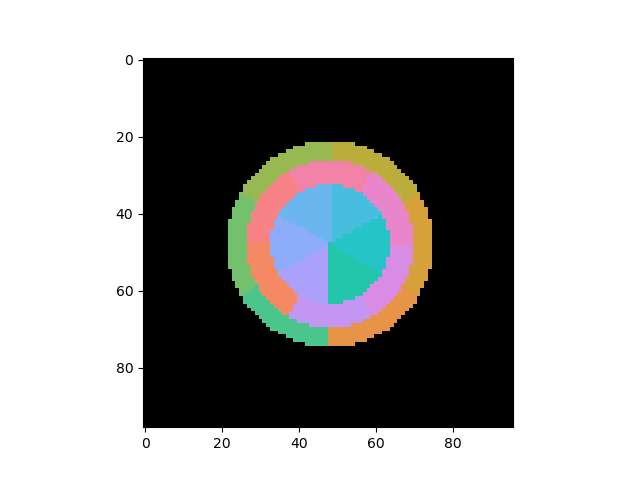

In [132]:
fig_text, ax_test = plt.subplots(1,1)
ax_test.imshow(ctf.combined_images_rgb(list(virtual_masks_annular)))
# ax_test.imshow(virtual_masks_annular[1])
plt.show()

In [112]:
rotate_half_the_rings.value

False

In [140]:
def update_figure(
    *args,
):
    """ """

    # compute new datasets
    # virtual_masks_annular = annular_segmented_detectors(
    #     gpts=(n,n),
    #     sampling=(sampling,sampling),
    #     n_angular_bins=number_of_segments_slider.value,
    #     inner_radius=inner_collection_angle_slider.value,
    #     outer_radius=outer_collection_angle_slider.value,
    #     rotation_offset=np.deg2rad(rotation_offset_slider.value),
    # )   
    virtual_masks_annular = []
    if area_toggle.value:
        ring_collection_angles = np.linspace(
            inner_collection_angle_slider.value**2,
            outer_collection_angle_slider.value**2,
            num=number_of_rings_slider.value + 1
        )**(1/2)
    else:
        ring_collection_angles = np.linspace(
            inner_collection_angle_slider.value,
            outer_collection_angle_slider.value,
            num=number_of_rings_slider.value + 1
        )
    if rotate_half_the_rings.value:
        ring_rotation = np.deg2rad((180/number_of_segments_slider.value))
    else:
        ring_rotation = 0
    for i in range(1,number_of_rings_slider.value+1):
        j = i-1
        virtual_masks_annular.append(
            annular_segmented_detectors(
                gpts=(n,n),
                sampling=(sampling,sampling),
                n_angular_bins=number_of_segments_slider.value,
                inner_radius=ring_collection_angles[j],
                outer_radius=ring_collection_angles[i],
                rotation_offset=np.deg2rad(rotation_offset_slider.value) + ring_rotation*(j%2),
            )
        )
    virtual_masks_annular = np.vstack(virtual_masks_annular)
    
    com_x, com_y = compute_com_using_virtual_detectors(
        intensities[0],
        virtual_masks_annular,
        intensities_sum[0],
        sx,sy,
        kxa,kya,
    )

    icom_annular = integrate_com(com_x,com_y,kx_op,ky_op)
    ctf_annular = ctf.compute_ctf(icom_annular) 

    q_bins_annular, I_bins_annular = ctf.radially_average_ctf(
        ctf_annular,
        (sampling,sampling)
    )

    # update data
    # 2D arrays
    im_detector.set_data(ctf.combined_images_rgb(virtual_masks_annular))
    im_ctf.set_data(ctf.histogram_scaling(np.fft.fftshift(ctf_annular),normalize=True))

    # set radial average
    plot_ctf.set_ydata(I_bins_annular)

    # collections (vlines)
    axs[3].collections[0].remove()
    axs[3].vlines([inner_collection_angle_slider.value,outer_collection_angle_slider.value],0,2,colors='k',linestyles='--',linewidth=1,)

    # re-draw figure
    fig.canvas.draw_idle()
    return None

inner_collection_angle_slider.observe(update_figure,names='value')
outer_collection_angle_slider.observe(update_figure,names='value')
number_of_segments_slider.observe(update_figure,names='value')
rotation_offset_slider.observe(update_figure,names='value')
number_of_rings_slider.observe(update_figure,names='value')
rotate_half_the_rings.observe(update_figure,names='value')
area_toggle.observe(update_figure,names='value')

In [141]:
def simulate(
    defocus,
):
    """ """
    intensities[0], probe_array_fourier[0] = simulate_intensities(
        defocus=defocus,
    )

    update_analytical()
    
    update_figure("dummy")
    
    return None

In [142]:
def update_analytical():
    """ """
    
    intensities_sum[0] = intensities[0].sum((-1,-2))

    # Analytical CTF (probe autocorrelation)
    ctf_analytic = np.real(
        np.fft.ifft2(
            np.abs(
                np.fft.fft2(
                    probe_array_fourier[0]
                )
            )**2
        )
    )
    
    # Radially-averaged CTF
    q_bins_analytic, I_bins_analytic = ctf.radially_average_ctf(ctf_analytic,(sampling,sampling))

    # analytic
    im_ctf_analytic.set_data(ctf.histogram_scaling(np.fft.fftshift(ctf_analytic),normalize=True))

    # set radial average
    plot_ctf_analytic.set_ydata(I_bins_analytic)

    fig.canvas.draw_idle()
    return None

In [143]:
#| label: app:annular_segmented_icom
# Annular Segmented Detectors

display(
    ipywidgets.VBox(
        [
            ipywidgets.VBox(
                [
                    ipywidgets.HBox([defocus_slider, simulate_button]),
                    ipywidgets.HBox([inner_collection_angle_slider,outer_collection_angle_slider]),
                    ipywidgets.HBox([number_of_segments_slider,rotation_offset_slider]),
                    ipywidgets.HBox([number_of_rings_slider,rotate_half_the_rings,area_toggle]),
                ]
            ),
            fig.canvas
        ]
    )
)